In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols


Dane pochodzą z platformy kaggle.com

In [2]:
data = pd.read_csv('./data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


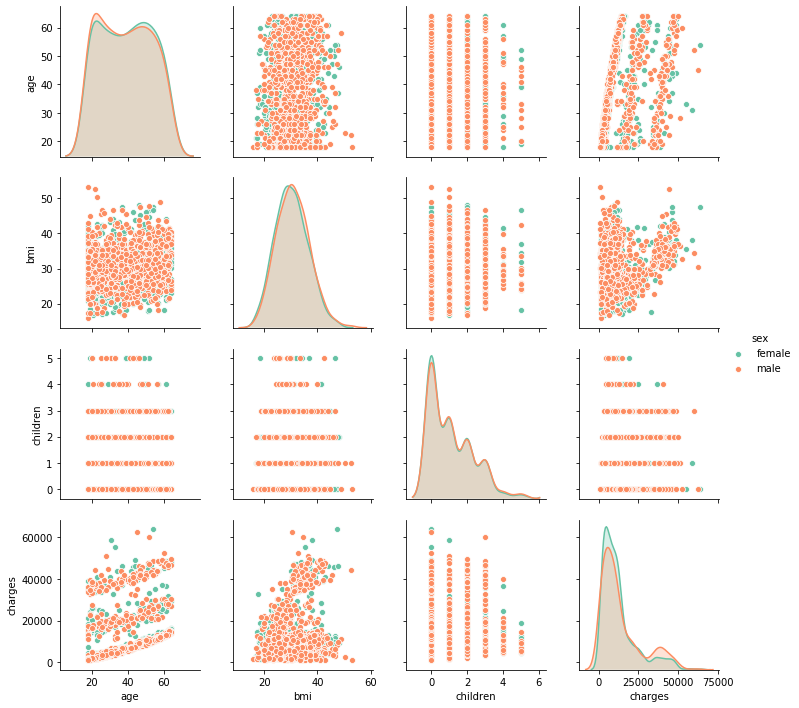

In [3]:
sns.pairplot(data, kind="scatter",  vars=['age','bmi','children','charges'], hue ='sex', palette='Set2')
#plt.suptitle("Scatterplots dla zmiennych ilościowych w podziale na płeć", size = 20)
plt.show;

Regresja działa na zmiennych ilościowych, więc należy zamienić kategoryczne na numeryczne

In [4]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
cat_columns = data.select_dtypes(['object']).columns
cat_columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [6]:
def cat_to_int (data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data

In [7]:
data = cat_to_int(data, cat_columns)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


In [8]:
print('Max: ',data['charges'].max())
print('Min: ',data['charges'].min())

Max:  63770.42801
Min:  1121.8739


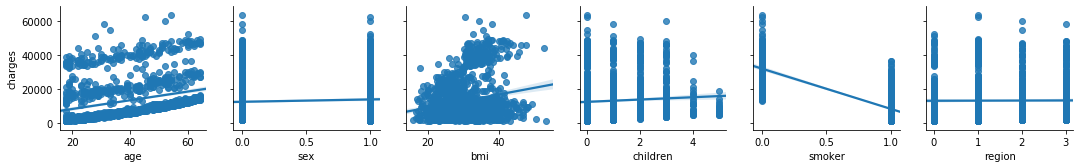

In [9]:
sns.pairplot(data, x_vars=['age','sex','bmi','children','smoker','region'], y_vars=['charges'], kind="reg");
plt.show;

In [10]:
data.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,0.025019,-0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,-0.076185,-0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,-0.003750,-0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,-0.007673,-0.016569,0.067998
smoker,0.025019,-0.076185,-0.003750,-0.007673,1.000000,-0.002181,-0.787251
region,-0.002127,-0.004588,-0.157566,-0.016569,-0.002181,1.000000,0.006208
charges,0.299008,0.057292,0.198341,0.067998,-0.787251,0.006208,1.000000


#### Model

In [11]:
X = data.iloc[:,:-1]
y= data['charges']

In [12]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2809)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 27 to 1327
Data columns (total 6 columns):
age         896 non-null int64
sex         896 non-null int64
bmi         896 non-null float64
children    896 non-null int64
smoker      896 non-null int64
region      896 non-null int64
dtypes: float64(1), int64(5)
memory usage: 49.0 KB


In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 1239 to 7
Data columns (total 6 columns):
age         442 non-null int64
sex         442 non-null int64
bmi         442 non-null float64
children    442 non-null int64
smoker      442 non-null int64
region      442 non-null int64
dtypes: float64(1), int64(5)
memory usage: 24.2 KB


#### Podstawowa wersja regresji
Bez testów, walidacji itp. - tylko by pokazać jak liczyć i jaki wynik dostajemy

In [15]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Intercept:', regr.intercept_)
print('Coefficients:', regr.coef_)

Intercept: 11767.393403725486
Coefficients: [   256.56871667   -134.35769256    302.44722544    419.45430125
 -23292.04261028    172.0124199 ]


Intercept to punkt przecięcia, a coefficients to współczynniki dla konkretnych zmiennych. Podane są w takiej kolejności jak kolejno są ułozone kolumny w zbiorze uczący.
Na ich podstawie można zapisać równanie matemtyczne i obliczyć zmienną (charges) dla nowych danych

In [16]:
age_ = 37
sex_ = 0
bmi_ = 27.7
children_ = 1
smoker_ = 0
region_ = 1
print ('Charges dla niepalącej kobiety o bmi 27,7 posiadającej 1 dziecko i mieszkającej w regionie southeast wynosi: ', regr.predict([[age_, sex_, bmi_, children_, smoker_, region_]]))

Charges dla niepalącej kobiety o bmi 27,7 posiadającej 1 dziecko i mieszkającej w regionie southeast wynosi:  [30229.69078649]


Sprawdźmy **metryki** modelu:

In [17]:
print('Linear Regression R squared: %.4f' % regr.score(X_test, y_test))

Linear Regression R squared: 0.7856


Wynik ten to „R-kwadrat”, wartość w zakresie od 0 do 1, która opisuje proporcję wariancji w zmiennej wyjaśnionej przez model.
W  modelu 78,56% zmienności w y(charges) można wytłumaczyć za pomocą zmiennych.

Policzmy jeszcze błąd średniej kwadratowej (RMSE), który jest miarą wydajności modelu. Jest to sposób mierzenia czy model predykcyjny jest dobry w odniesieniu do rzeczywstych danych, im niższe RMSe tym lepiej.


In [18]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.2f'%rmse )
mse = np.mean((regr.predict(X_test) - y_test) ** 2)
print('MSE: %.2f'%mse)

RMSE: 5866.37
MSE: 34414254.88


RMSE jest wyrazony w tych samych jednostkach co  zależna zmienna y i w tym przypadku oznacza że średnio predykcja zmiennej ma błąd ok. 5866. Charges waha się między 1121.8739 a 63770.42801
więc błąd 5866 jest nie do przyjęcia.

In [27]:
def regresja(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2809)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    print('Intercept:', regr.intercept_)
    print('Coefficients:', regr.coef_)
    print('Linear Regression R squared: %.4f' % regr.score(X_test, y_test))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mse = np.mean((regr.predict(X_test) - y_test) ** 2)
    print('RMSE: %.2f'%rmse )
    print('MSE: %.2f'%mse)
    
    X2 = sm.add_constant(X)
 
    model = sm.OLS(y, X2).fit()
    predictions = model.predict(X2) 
 
    print_model = model.summary()
    print('\n ', print_model) 

In [20]:
X2 =data[data.columns.drop(['charges','sex'])]
y2 =data['charges']

In [28]:
regresja(X2,y2)b

Intercept: 11709.662816991666
Coefficients: [   256.71263706    301.63825482    417.94657642 -23278.13942659
    170.96010747]
Linear Regression R squared: 0.7855
RMSE: 5867.02
MSE: 34421929.08

                              OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     802.2
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        21:25:10   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
             

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [29]:
X3 =data[data.columns.drop(['charges','sex','smoker'])]
y3 =data['charges']

regresja(X3,y3)

Intercept: -4925.396572508336
Coefficients: [238.61474534 257.49828076 351.92359269 281.99314282]
Linear Regression R squared: 0.1377
RMSE: 11763.63
MSE: 138383017.88

                              OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     46.00
Date:                Wed, 27 May 2020   Prob (F-statistic):           3.07e-36
Time:                        21:26:21   Log-Likelihood:                -14391.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1333   BIC:                         2.882e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err        

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [30]:
X4 =data[data.columns.drop(['charges','sex','smoker','region'])]
y4 =data['charges']

regresja(X4,y4)

Intercept: -4212.252135616767
Coefficients: [238.20105512 248.34716621 348.87633847]
Linear Regression R squared: 0.1356
RMSE: 11777.63
MSE: 138712566.76

                              OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Wed, 27 May 2020   Prob (F-statistic):           8.80e-37
Time:                        21:27:10   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Trenowanie modeli

Regresje posiada różne typy : LinearRegression, Ridge, Lasso, ElasticNet

In [23]:
regressors = {}
regressors['LinearRegression'] =linear_model.LinearRegression()
regressors['Ridge'] = linear_model.Ridge(alpha = .5)
regressors['Lasso'] = linear_model.Lasso(alpha = 5.1)
regressors['ElasticNet'] = linear_model.ElasticNet(alpha = .5, l1_ratio=0.5)
fit_results={}

for key in regressors:
    regr = regressors[key]
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    mse = np.mean((regr.predict(X_test) - y_test) ** 2)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    w = regr.coef_
    
    wl1 = np.sum(np.abs(w))
    wl2 = np.sqrt(np.sum(w**2))
    
    fit_results[key]= { 'mse': mse, 'rmse':rmse, 'wl2': wl2, 'wl1': wl1, 'w': w}
    print("{}\n----------\n  mse={}\n  rmse={}\n  wl1={}\n  wl2={}\n  w={}\n ".format(key,mse,rmse,wl1,wl2,w))

LinearRegression
----------
  mse=34414254.87786168
  rmse=5866.366411831235
  wl1=24576.882966105117
  wl2=23300.217444536047
  w=[   256.56871667   -134.35769256    302.44722544    419.45430125
 -23292.04261028    172.0124199 ]
 
Ridge
----------
  mse=34458955.94776899
  rmse=5870.175120707133
  wl1=24489.22863638299
  wl2=23218.743154112595
  w=[   256.51209028   -128.61249599    302.25303704    419.00504113
 -23210.58157142    172.26440052]
 
Lasso
----------
  mse=34440687.49810861
  rmse=5868.618874838323
  wl1=24510.49120942006
  wl2=23265.722604378156
  w=[   256.5587779    -111.03036599    301.99053465    415.69572983
 -23257.76552763    167.45027342]
 
ElasticNet
----------
  mse=76163854.8188018
  rmse=8727.19054557661
  wl1=10508.624348235406
  wl2=9096.908362564196
  w=[  246.09852067   408.81662646   269.50306467   319.81008021
 -9072.72832912   191.6677271 ]
 


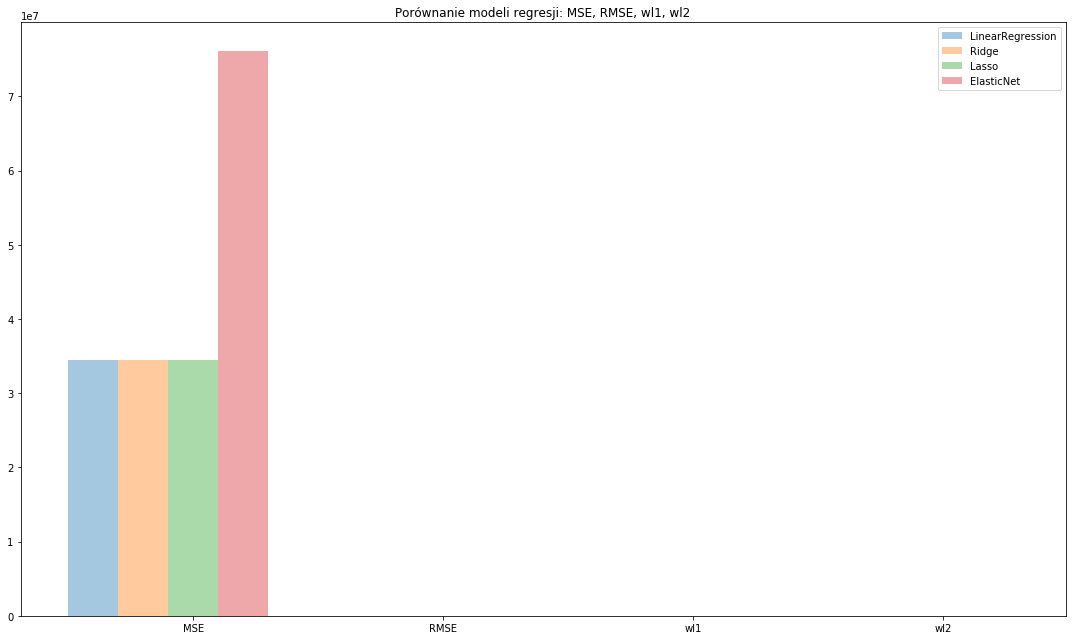

In [24]:
groups = 4
index = np.arange(groups)
bar_width = .2
opacity = 0.4
fig, ax = plt.subplots(figsize=(15,9))
t=0
for key in regressors:
    results = fit_results[key]
    res_val = (results['mse'],results['rmse'],results['wl1'],results['wl2'])
    plt.bar(index+ bar_width*t, res_val, bar_width, alpha=opacity, label=key)
    t+=1

plt.title('Porównanie modeli regresji: MSE, RMSE, wl1, wl2')
plt.xticks(index + (t-2)*bar_width, ('MSE','RMSE', 'wl1', 'wl2'))
plt.legend()
plt.tight_layout()
plt.show()